In [83]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import electric_rates as er
from vehicles import vehicle_ev, vehicle_ice, gas_costs_per_month, electr_cost_per_month

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
gas_costs = np.linspace(2.00, 4.00, 10)

erates = er.elect_rates()
erates.add_sdge_tou_ev_rates()
miles_per_month = 15000.0/12.0

## Cars
volt = vehicle_ev("Volt 2016", 0.37)
grand_vitara = vehicle_ice("grand vitara", 19, 23, average_override=21)
mazda_3 = vehicle_ice("Mazda 3 2.5l", 28, 39 )
sienna = vehicle_ice("Sienna", 19,25)
gti = vehicle_ice( "GTI", 25,33 )

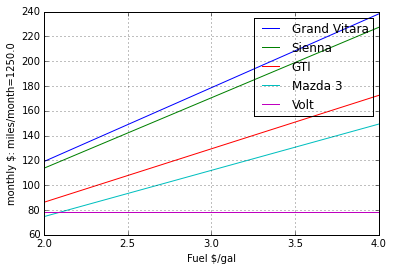

In [94]:
gv_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, grand_vitara.get_ave_mpg() )
mazda_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, mazda_3.get_ave_mpg() )
sienna_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, sienna.get_ave_mpg() )
gti_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, gti.get_ave_mpg() )
volt_costs_monthly = electr_cost_per_month( miles_per_month, erates.get_ave_rate(), volt.kwh_per_mile )
plt.plot(gas_costs, gv_costs_monthly, label="Grand Vitara")
plt.plot(gas_costs, sienna_costs_monthly, label="Sienna")
plt.plot(gas_costs, gti_costs_monthly, label="GTI")
plt.plot(gas_costs, mazda_costs_monthly, label="Mazda 3")
plt.plot(gas_costs, [volt_costs_monthly]*gas_costs.shape[0], label="Volt" )
plt.xlabel("Fuel $/gal")
plt.ylabel("monthly $: miles/month="+str(miles_per_month))
plt.legend()
plt.grid()
plt.show()

In [90]:
dt = datetime.datetime( year=2015, month=8, day=1, hour=11)
erates.get_rate(dt)

0.2

In [92]:
e_daily = pd.read_csv("electric-usage--raw.csv")
e_daily

,Date,Start Time,Duration,Value,Edit Code,Flow Direction,TOU
0,7/19/2014,12:00 AM,60,0.265,Direct,NaN,NoTOU
1,7/19/2014,1:00 AM,60,0.195,Direct,NaN,NoTOU
2,7/19/2014,2:00 AM,60,0.180,Direct,NaN,NoTOU
3,7/19/2014,3:00 AM,60,0.275,Direct,NaN,NoTOU
4,7/19/2014,4:00 AM,60,0.200,Direct,NaN,NoTOU
5,7/19/2014,5:00 AM,60,0.220,Direct,NaN,NoTOU
6,7/19/2014,6:00 AM,60,0.170,Direct,NaN,NoTOU
7,7/19/2014,7:00 AM,60,0.170,Direct,NaN,NoTOU
8,7/19/2014,8:00 AM,60,0.170,Direct,NaN,NoTOU
9,7/19/2014,9:00 AM,60,0.170,Direct,NaN,NoTOU
